<a href="https://colab.research.google.com/github/mniarwyc/youtube_views_prediction/blob/main/%D0%9F%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BF%D0%BE%D0%BF%D1%83%D0%BB%D1%8F%D1%80%D0%BD%D0%BE%D1%81%D1%82%D0%B8_%D0%BC%D1%83%D0%B7%D1%8B%D0%BA%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D1%85_%D0%B2%D0%B8%D0%B4%D0%B5%D0%BE_YouTube_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.7 MB/s eta 0:00:00


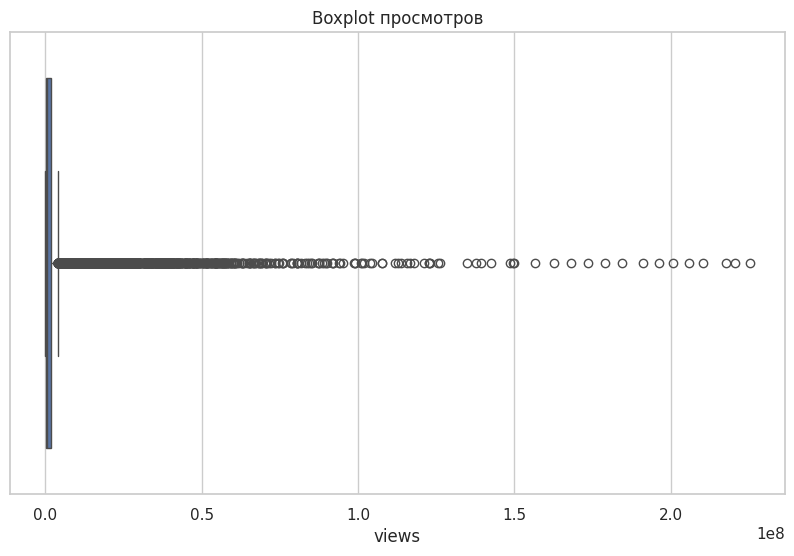

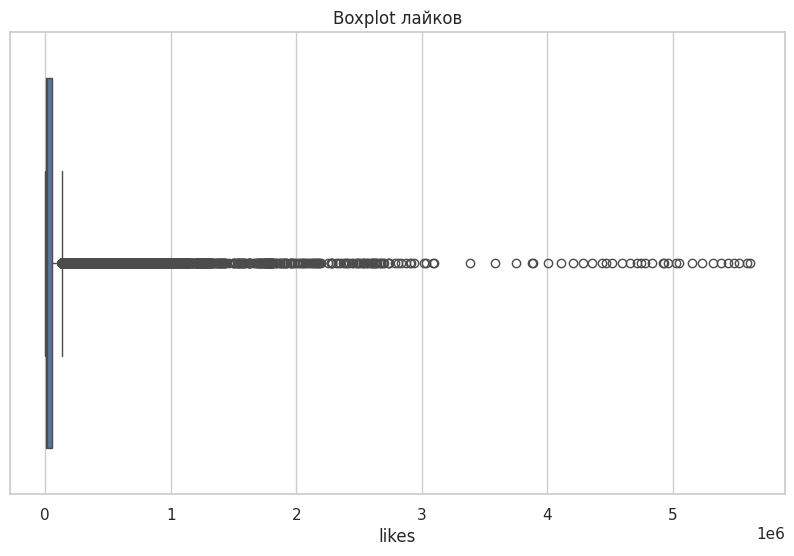

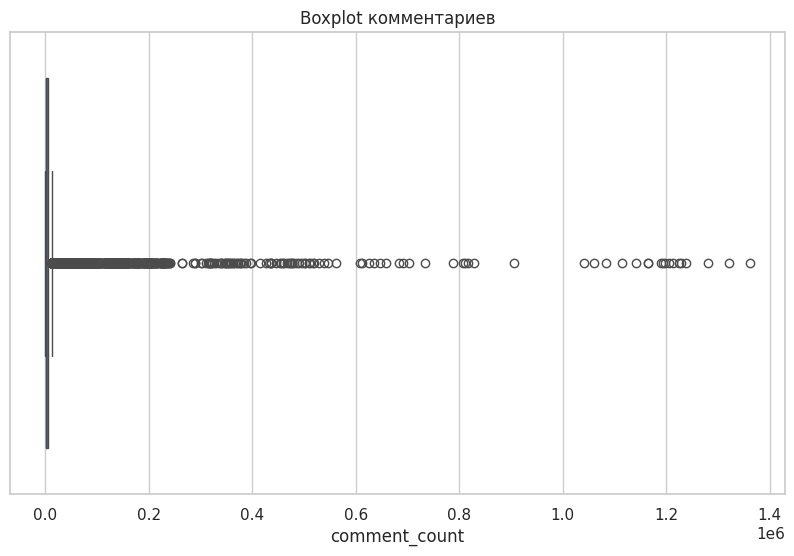

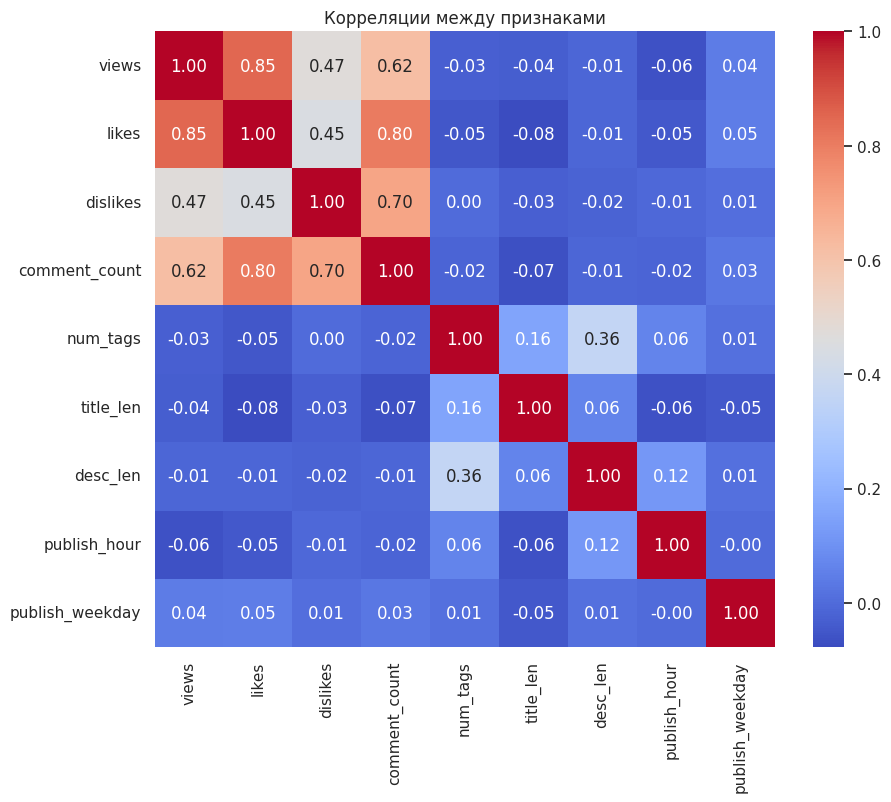

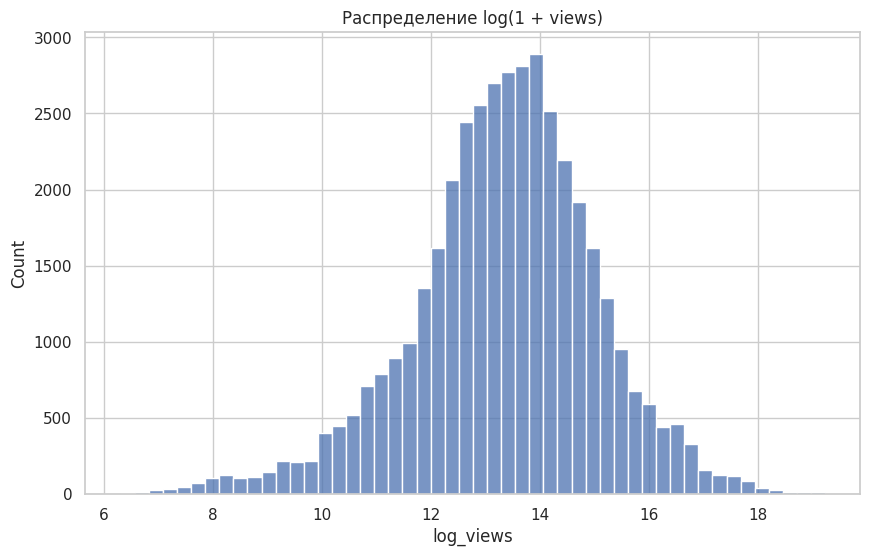

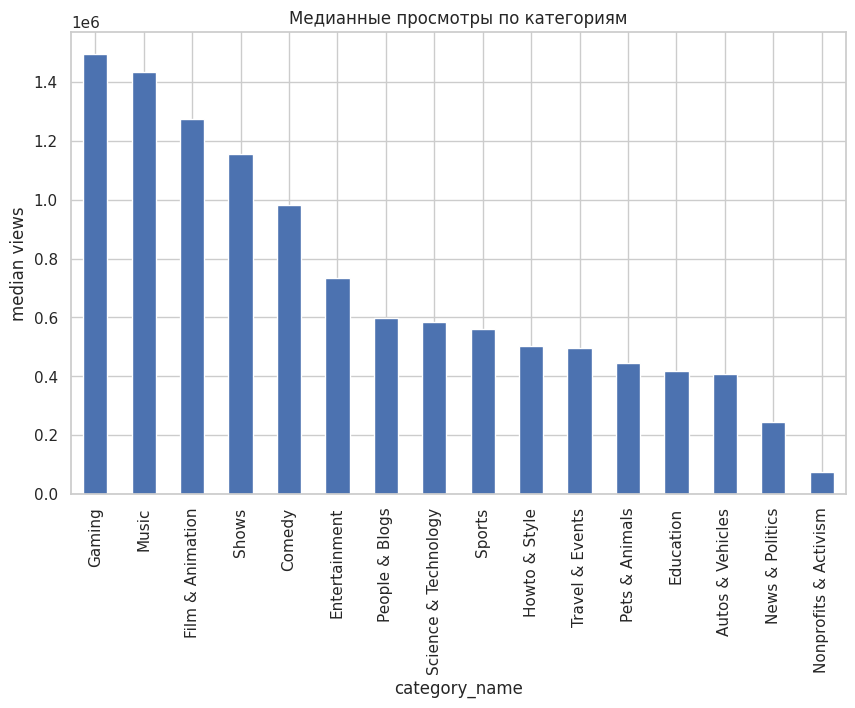

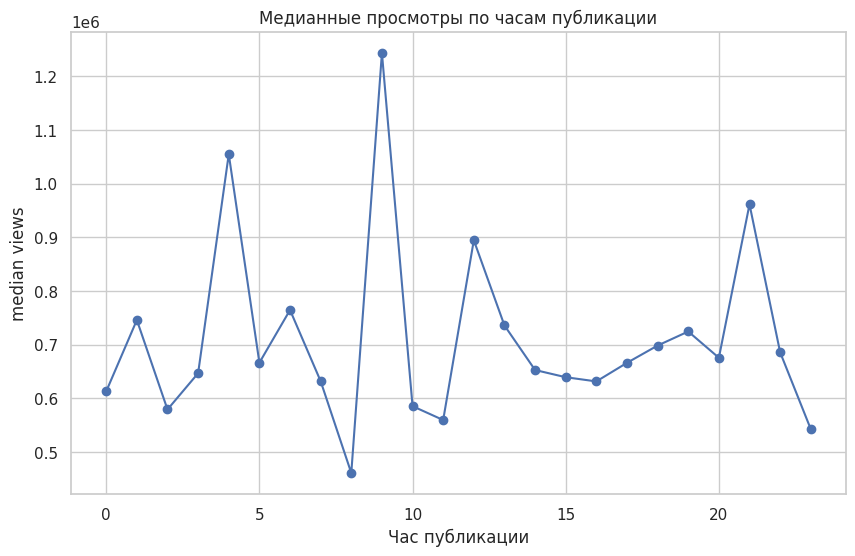

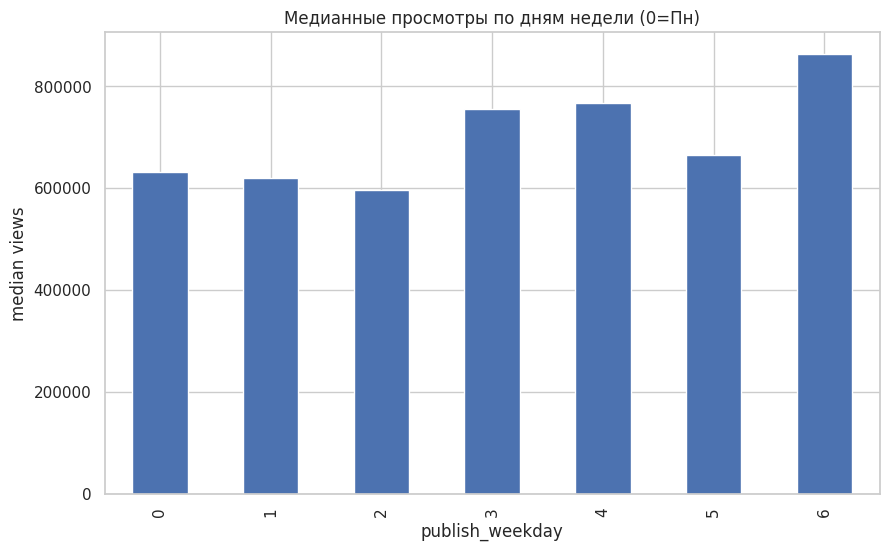


Обучение модели: LinearRegression
LinearRegression — MAE (views): 2060689221.33, R2 (log): 0.2933, RMSE (log): 1.4447

Обучение модели: RandomForest
RandomForest — MAE (views): 241047.85, R2 (log): 0.9662, RMSE (log): 0.3159

Обучение модели: XGBoost
XGBoost — MAE (views): 613949.42, R2 (log): 0.9250, RMSE (log): 0.4707

Сравнение моделей:
                     MAE_views    R2_log  RMSE_log
RandomForest      2.410479e+05  0.966215  0.315891
XGBoost           6.139494e+05  0.924972  0.470746
LinearRegression  2.060689e+09  0.293334  1.444715
Лучшая модель: RandomForest, сохранена в /content/best_youtube_model.pkl
Файл с предсказаниями: /content/test_predictions.csv


In [4]:
# -*- coding: utf-8 -*-
"""
Проект: Прогнозирование просмотров YouTube (США)
Полностью рабочий Colab-ready код
"""

# 0. Установка необходимых библиотек (раскомментируй и запусти один раз)
!pip install catboost xgboost isodate --quiet

# 1. Импорты
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import joblib
import json
import isodate

plt.rcParams['figure.figsize'] = (10,6)
sns.set(style='whitegrid')

# 2. Вспомогательные функции
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def parse_duration(s):
    try:
        if pd.isna(s):
            return np.nan
        if isinstance(s,(int,float)):
            return s
        if isinstance(s,str) and s.startswith('PT'):
            d = isodate.parse_duration(s)
            return d.total_seconds()
        parts = s.split(':')
        parts = [float(p) for p in parts]
        if len(parts)==2:
            return parts[0]*60 + parts[1]
        if len(parts)==3:
            return parts[0]*3600 + parts[1]*60 + parts[2]
        return np.nan
    except:
        return np.nan

# 3. Загрузка данных
videos_file = '/content/USvideos.csv'
categories_file = '/content/US_category_id.json'

df_videos = pd.read_csv(videos_file)
with open(categories_file, 'r', encoding='utf-8') as f:
    cat_data = json.load(f)

categories = pd.json_normalize(cat_data, record_path=['items'])
categories = categories[['id','snippet.title']]
categories.columns = ['category_id','category_name']

df_videos['category_id'] = pd.to_numeric(df_videos['category_id'], errors='coerce')
categories['category_id'] = pd.to_numeric(categories['category_id'], errors='coerce')

df = df_videos.merge(categories, on='category_id', how='left')

# 4. Очистка данных и создание признаков
df['views'] = pd.to_numeric(df['views'], errors='coerce').fillna(0)
df['likes'] = pd.to_numeric(df['likes'], errors='coerce').fillna(0)
df['dislikes'] = pd.to_numeric(df['dislikes'], errors='coerce').fillna(0)
df['comment_count'] = pd.to_numeric(df['comment_count'], errors='coerce').fillna(0)

df['tags'] = df['tags'].fillna('')
df['num_tags'] = df['tags'].apply(lambda x: 0 if x=='' else len(x.split('|')))
df['title_len'] = df['title'].astype(str).apply(len)
df['description'] = df['description'].fillna('')
df['desc_len'] = df['description'].astype(str).apply(len)

df['publish_time'] = pd.to_datetime(df['publish_time'], errors='coerce')
df['publish_hour'] = df['publish_time'].dt.hour
df['publish_weekday'] = df['publish_time'].dt.weekday

# 5. Анализ выбросов (бокплоты)
plt.figure()
sns.boxplot(x=df['views'])
plt.title('Boxplot просмотров')
plt.show()

plt.figure()
sns.boxplot(x=df['likes'])
plt.title('Boxplot лайков')
plt.show()

plt.figure()
sns.boxplot(x=df['comment_count'])
plt.title('Boxplot комментариев')
plt.show()

# 6. Корреляции
num_cols = ['views','likes','dislikes','comment_count','num_tags','title_len','desc_len','publish_hour','publish_weekday']
corr = df[num_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Корреляции между признаками')
plt.show()

# 7. Логарифмирование просмотров
df['log_views'] = np.log1p(df['views'])
plt.figure()
sns.histplot(df['log_views'], bins=50)
plt.title('Распределение log(1 + views)')
plt.show()

# 8. Популярность по категориям
median_views = df.groupby('category_name')['views'].median().sort_values(ascending=False)
plt.figure()
median_views.plot(kind='bar')
plt.title('Медианные просмотры по категориям')
plt.ylabel('median views')
plt.show()

# 9. Популярность по часам публикации
hour_views = df.groupby('publish_hour')['views'].median()
plt.figure()
hour_views.plot(kind='line', marker='o')
plt.title('Медианные просмотры по часам публикации')
plt.xlabel('Час публикации')
plt.ylabel('median views')
plt.show()

# 10. Популярность по дням недели
weekday_views = df.groupby('publish_weekday')['views'].median()
plt.figure()
weekday_views.plot(kind='bar')
plt.title('Медианные просмотры по дням недели (0=Пн)')
plt.ylabel('median views')
plt.show()

# 11. Фичи для модели
feature_cols = ['likes','dislikes','comment_count','num_tags','title_len','desc_len','publish_hour','publish_weekday','category_name']
X = df[feature_cols]
y = df['log_views']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 12. Пайплайн препроцессинга
numeric_features = ['likes','dislikes','comment_count','num_tags','title_len','desc_len','publish_hour','publish_weekday']
categorical_features = ['category_name']

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# 13. Модели
models = {
    'LinearRegression': Pipeline([('preprocessor', preprocessor), ('regressor', LinearRegression())]),
    'RandomForest': Pipeline([('preprocessor', preprocessor), ('regressor', RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))]),
    'XGBoost': Pipeline([('preprocessor', preprocessor), ('regressor', XGBRegressor(n_estimators=200, learning_rate=0.05, random_state=42, n_jobs=4))])
}

# 14. Обучение и оценка моделей
results = {}
for name, pipe in models.items():
    print(f"\nОбучение модели: {name}")
    pipe.fit(X_train, y_train)
    pred_log = pipe.predict(X_test)
    y_test_orig = np.expm1(y_test)
    pred_orig = np.expm1(pred_log)
    mae = mean_absolute_error(y_test_orig, pred_orig)
    r2 = r2_score(y_test, pred_log)
    rm = rmse(y_test, pred_log)
    results[name] = {'MAE_views': mae, 'R2_log': r2, 'RMSE_log': rm}
    print(f"{name} — MAE (views): {mae:.2f}, R2 (log): {r2:.4f}, RMSE (log): {rm:.4f}")

# 15. Сравнение моделей
res_df = pd.DataFrame(results).T
print("\nСравнение моделей:")
print(res_df.sort_values('MAE_views'))

best_model_name = res_df['MAE_views'].idxmin()
best_model = models[best_model_name]
joblib.dump(best_model, '/content/best_youtube_model.pkl')
print(f"Лучшая модель: {best_model_name}, сохранена в /content/best_youtube_model.pkl")

# 16. Сохранение предсказаний
pred_log = best_model.predict(X_test)
out_df = X_test.copy()
out_df['pred_log_views'] = pred_log
out_df['pred_views'] = np.expm1(pred_log)
out_df['true_views'] = np.expm1(y_test)
out_df.to_csv('/content/test_predictions.csv', index=False)
print("Файл с предсказаниями: /content/test_predictions.csv")
